# Noise analysis for a quantum memory experiment

*Want to follow along? {nb-download}`Download this notebook.<noise_analysis.ipynb>`*

In this notebook we demonstrate all the steps required to perform noise source analysis for a quantum error correction experiment. Specifically, we will be using data from a quantum memory experiment published by Google ([Google Quantum AI, _Nature 614, 676-681_ (2023)](https://www.nature.com/articles/s41586-022-05434-1)) and calculate defect rates and correlation matrices. In the [Decoding a quantum memory experiment](decode.ipynb) example notebook, we decoded this data to obtain logical error probabilities for different experiment scenarios. In this notebook, we will explore the experiment data further, generating insights into the errors that are occurring on the quantum computer during the experiment.

This notebook covers the following steps: 

- Preparation 
- The experiment 
- Detectors and observables 
- Defect rates 
- Correlation matrices

## Preparation
### Perform all necessary imports

In [1]:
from __future__ import annotations

from pathlib import Path

import matplotlib.pyplot as plt
import stim
from deltakit.explorer import Logging, Client, visualisation
from deltakit.explorer.enums import DataFormat
from deltakit.explorer.types import BinaryDataType, Measurements, QECExperiment

### Set up server and data folder

In [2]:
client = Client.get_instance()
data_folder = Path("../..") / "data/examples"

Logging.set_log_to_console(False)

### Downloading data

For this notebook you will need to download experimental data. You may manually download it from [https://zenodo.org/records/6804040](https://zenodo.org/records/6804040), or run the following script:

In [3]:
! if [ ! -e "../../data/examples/google_qmem_experiment/input" ]; then ../../scripts/get_google_data.sh ../../data ; fi

## The experiment

To demonstrate how Deltakit can be used to perform noise analysis for a quantum error correction experiment, we will use data from a quantum memory experiment published by Google ([Google Quantum AI, _Nature 614, 676-681_, 2023](https://www.nature.com/articles/s41586-022-05434-1)). The aim of the experiment is to preserve the state of a single logical qubit through time. A selection of the data is available in the examples data folder – the locations of the necessary input data are specified in the cell below.

The measurement file contains the measurement values (0s and 1s) for each measurement made in each run of the experiment. The STIM circuit file gives the specific gates that were run and also defines which combinations of measurements make up the detectors. The input STIM circuit is referred to as ideal because it does not contain noise.

An additional file is made use of here – a file containing sweep bit values. This file is used to vary the starting state in the experiment. This may not be part of the setup of other experiments – in such cases, the file can be omitted. 

In this notebook, we are considering a specific experiment with a fixed number of rounds. The experiment can be changed in the following cell by changing the value of the `rounds` variable. 

In [4]:
rounds = 7
data_format = DataFormat.B8

z_data_folder = data_folder / f"google_qmem_experiment/input/surface_code_bZ_d3_r{str(rounds).zfill(2)}_center_3_5/"
x_data_folder = data_folder / f"google_qmem_experiment/input/surface_code_bX_d3_r{str(rounds).zfill(2)}_center_3_5/"
z_and_x_experiment_folders = [z_data_folder, x_data_folder]
measurements_file = z_data_folder / "measurements.b8"
stim_circuit_file = z_data_folder / "circuit_ideal.stim"
sweep_file = z_data_folder / "sweep.b8"

## Detectors and Observables 

In order to perform the noise analysis, we first need to calculate the detector and observable values from the measurement outcomes.

Detectors are combinations of measurements of the qubits that should have deterministic values in the absence of errors. The specific measurements that are taken depends on the quantum error correction code being used. In the examples considered in these notebooks, the surface code is used, which is a stabiliser code. When using a stabiliser code, measurements of multi-qubit operators known as stabilisers are taken in every round of the experiment. Each stabiliser is measured using an auxiliary qubit. The detectors are then defined to be the difference between stabiliser measurements in consecutive rounds.

An observable is also a combination of measurements that has deterministic value in the absence of errors. However, the observable is not used to detect errors that have occurred – it is instead what we wish to preserve by performing error correction. For example, in a **Z**-quantum-memory experiment, we prepare the logical qubit in the logical `|0⟩` state, measure the stabilisers for some number of rounds and then measure out the qubits. The observable is the combination of measurements that give us measurement of the logical-**Z** operator – we hope that, having decoded our detector outcomes, this gives a value of 0 for this particular example.

### Convert raw measurement into detector and observable values

In [5]:
stim_circuit = stim.Circuit.from_file(stim_circuit_file)
# if we use bitpacked b8 format, we should hint the width of the data in 1 shot
measurements = Measurements(measurements_file, data_format, stim_circuit.num_measurements)
sweep_bits = BinaryDataType(sweep_file, data_format, stim_circuit.num_sweep_bits)  # use generic type for bit tables
detectors, observables = measurements.to_detectors_and_observables(stim_circuit, sweep_bits)

## Defect Rates 

A defect rate is the proportion of the time that a particular detector changes value, indicating an error has occurred.  

Here, we select a particular auxiliary qubit coordinate and calculate defect rates for detectors constructed from measurements of this auxiliary qubit. 

In [6]:
coordinate = (2.0, 5.0)

defect_rates = client.defect_rates(detectors, stim_circuit)

### Plot defect rate

We now plot the defect rate per round moving through the experiment. Examining the rate’s time dependence provides insight into how the errors that cause the defect vary as a function of time. 

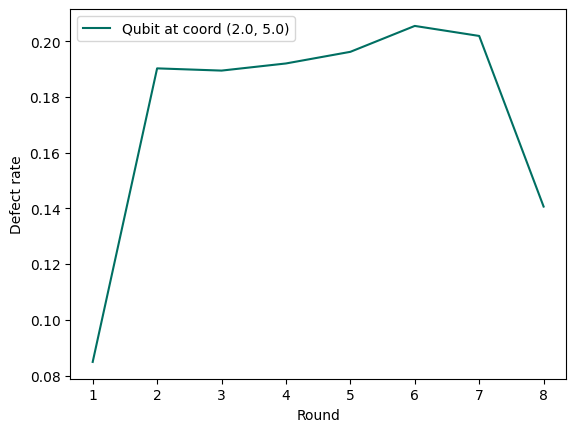

In [7]:
plt.plot(range(1, len(defect_rates[coordinate]) + 1), defect_rates[coordinate], color="#006f62",
         label=f"Qubit at coord {coordinate}")
plt.xlabel("Round")
plt.xticks(range(1, rounds+2))
plt.ylabel("Defect rate")
plt.legend()

### Plot all defect rate lines for a given experiment

We now plot the defect rate for each detector in the experiment over time. The orange lines are weight-2 detectors on the boundary of the code, and the green lines are weight-4 detectors in the bulk of the code. Dark lines are averages across all detectors of a given weight, while lighter lines are the rate for an individual detector. This gives us an indication of not just when errors are occurring overall but also when they are causing specific detectors to flip.

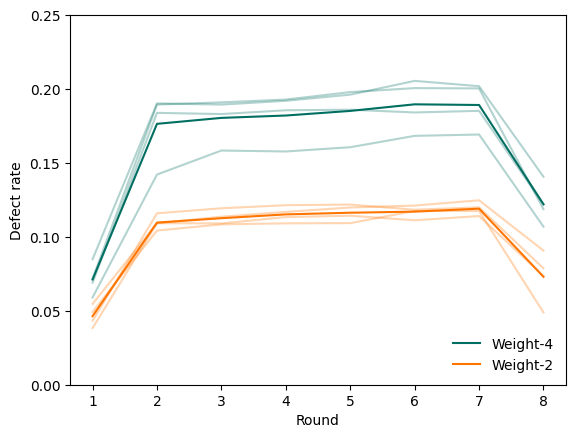

In [ ]:
experiments = [
    QECExperiment.from_circuit_and_measurements(
        folder / "circuit_noisy.stim",
        folder / "measurements.b8", DataFormat.B8,
        folder / "sweep.b8", DataFormat.B8,
    )
    for folder
    in z_and_x_experiment_folders
]
all_rates = []
all_mappings = []
for experiment in experiments:
    mapping, rates = client.get_experiment_detectors_and_defect_rates(experiment)
    all_mappings.append(mapping)
    all_rates.append(rates)
visualisation.defect_rates(all_rates, w2_det_coords=set({(5, 6), (1, 4), (4, 3), (2, 7)})).show()

### Plot defect heatmap

We now plot where on the rotated surface code memory experiment the defect rates are observed. Each shape on the map below represents a detector measuring the data qubits on the corners. Lighter colours indicate that defects were detected more frequently in those areas. 

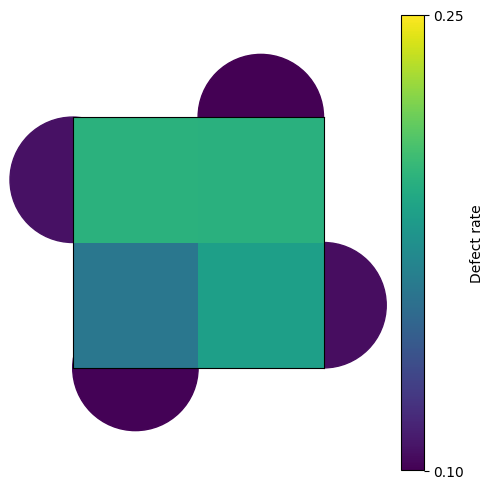

In [ ]:
# aggregate dictionaries for multiple experiments
all_defect_rates, all_detector_coords = {}, {}
for rates in all_rates:
    all_defect_rates.update(rates)
for coords in all_mappings:
    all_detector_coords.update(coords)

visualisation.defect_diagram(all_detector_coords, all_defect_rates).show()

## Correlation Matrices

We now plot correlation matrices for the experiment. In general, in the surface code, errors result in two detectors changing value. Using the experiment data, the correlation matrix displays the observed probabilities of these two-detector error events occurring. 

### Plot correlation matrix for only expected error mechanisms 

In the current noise model functionality we assume that the noise occurring on the device is limited to certain specific error mechanisms. If this is true, then only certain combinations of detectors will change value due to a single error. We can calculate the correlation matrix looking only at the pairs of detectors that would change value together due to such error mechanisms – this is what is calculated when `use_default_noise_model_edges` is set to `True`.

In [10]:
stim_graph_matrix, stim_graph_qubit_to_detector_mapping = client.get_correlation_matrix(
    detectors, stim_circuit,
    # we will look into default model noise mechanisms only
    # which will lead to "cleaner" correlation matrix
    use_default_noise_model_edges=True,
)

We now plot the correlation matrix. The large axis ticks correspond to auxiliary qubit coordinates and the small ticks indicate the different rounds. For example, the darkest green small boxes at the top right of the bottom left large box show the observed probability of an error occurring that causes the detectors associated with the stabiliser measured by qubit (2, 5) in the final and penultimate rounds to change value.

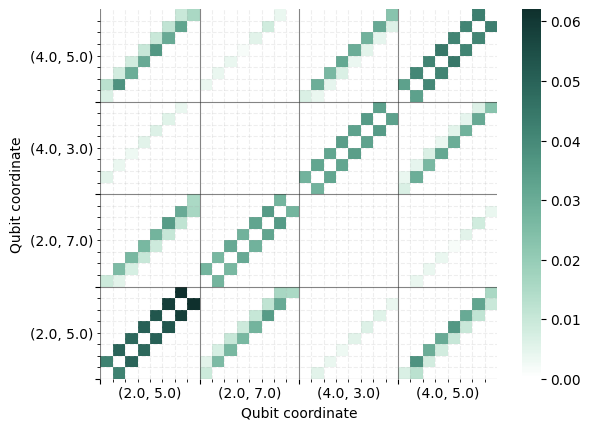

In [ ]:
visualisation.correlation_matrix(stim_graph_matrix, stim_graph_qubit_to_detector_mapping).show()

### Plot correlation matrix for all possible error mechanisms

In this case we are calculating and plotting the correlation matrix without filtering for expected error mechanisms. This is achieved by setting `use_default_noise_model_edges` to `False`. Comparing this correlation matrix with the previous one shows what errors are occurring that are unexpected.

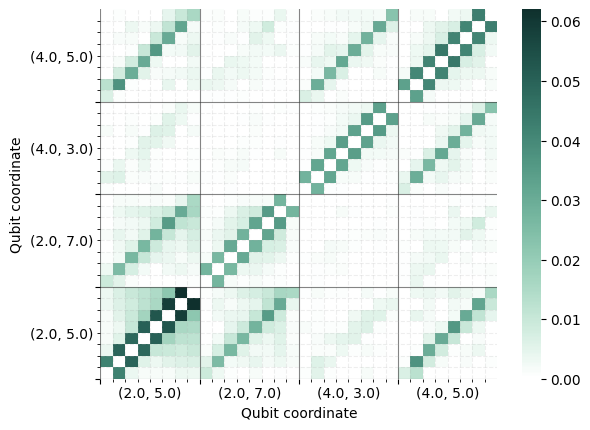

In [ ]:
matrix, qubit_to_detector_mapping = client.get_correlation_matrix(
    detectors, stim_circuit,
    use_default_noise_model_edges=False,
)
visualisation.correlation_matrix(matrix, qubit_to_detector_mapping).show()

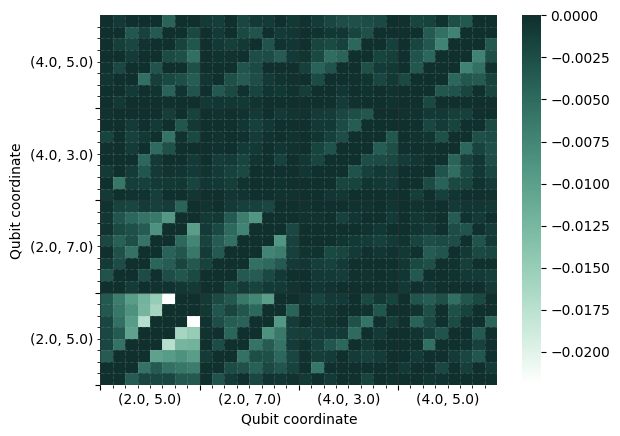

In [ ]:
visualisation.correlation_matrix(stim_graph_matrix - matrix, qubit_to_detector_mapping).show()